# Implementation Part

## Question 1 - Numerical and Practical Bit Allocation for TwoDimensional Signals

In [96]:
import imageio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.utils import shuffle
from matplotlib.pyplot import figure
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans
from skimage import io, color


A = 2500
w_x = 2
w_y = 7
x_size = 1024
y_size = 1024
bits = 8
d_phi = np.zeros((x_size,y_size), dtype = np.float64)
import math
def phi(x, y, A, w_x, w_y):
  a=2*math.pi*w_x*x
  b=2*math.pi*w_y*y
  return A  *math.cos(a) * math.sin(b)
def sampl(represent, signal, N_x, N_y, A, w_x, w_y):
  for i in range(N_y):
    for j in range(N_x):
      k1=j/(N_x-1)
      k2=i/(N_y-1)
      temp_res=signal(k1, k2, A, w_x, w_y)
      represent[i][j]= temp_res
  return represent
def uniform(sampled, b):
  delta = (sampled.max() - sampled.min())/(2**b)
  quantized_signal = sampled.min() + (np.floor((sampled - sampled.min())/delta)+0.5)*delta
  return quantized_signal

### Q1.b 

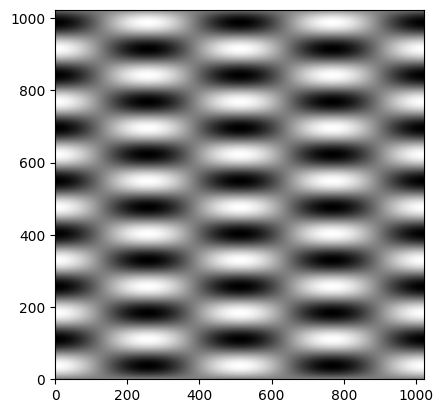

In [97]:
phi_plt = uniform(sampled=sampl(represent=d_phi, signal=phi, N_x=x_size, N_y=y_size, A=A, w_x=w_x, w_y=w_y), b=bits)
_ = plt.imshow((phi_plt+A)/2*A, cmap='gist_gray', origin='lower')

### Q1.c

In [98]:
def energy_L2(function_digitized, N_x, N_y):
  return np.sum((function_digitized**2)/(N_x*N_y))
def horizontal_derivative(x, y, A, w_x, w_y):
  a=2*math.pi*w_x*x
  b=2*math.pi*w_y*y
  return -A*2*math.pi*w_x*math.sin(a)*math.sin(b)

def vertical_derivative(x, y, A, w_x, w_y):
  a=2*math.pi*w_x*x
  b=2*math.pi*w_y*y
  return A*2*math.pi*w_y*math.cos(a)*math.cos(b)


In [99]:
horizontal_deriv = np.zeros((x_size,y_size), dtype = np.float64)
vertical_deriv = np.zeros((x_size,y_size), dtype = np.float64)
digitized_horizontal_derivative = uniform(sampl(horizontal_deriv, horizontal_derivative ,x_size, y_size, A, w_x, w_y), bits)
digitized_vertical_derivative = uniform(sampl(vertical_deriv, vertical_derivative, x_size, y_size, A, w_x, w_y), bits)
value_range = d_phi.max() - d_phi.min()
s1='vertical-derivative energy : ' + str(energy_L2(digitized_vertical_derivative, x_size, y_size))
s2='horizontal-derivative energy : ' + str(energy_L2(digitized_horizontal_derivative, x_size, y_size))
s3='Phi range is: [' + str(phi_plt.min()) + ' , ' + str(phi_plt.max()) + ']'
print(s1);
print(s2);
print(s3);

vertical-derivative energy : 3028459379.4495306
horizontal-derivative energy : 246261562.3985023
Phi range is: [-2490.2314393881684 , 2509.762666363762]


implementing the numerical parameter calculation

In [100]:
def best_calc(horizontal_e, vertical_e, range_v, budget):
  b = math.log2((budget*(range_v**2) * math.log(2)) / math.sqrt(horizontal_e * vertical_e)) / 2
  N_x = math.sqrt((budget/b) * math.sqrt(horizontal_e / vertical_e))
  N_y = N_x * math.sqrt(vertical_e / horizontal_e)
  if(round(b)*round(N_x)*round(N_y)>budget):
    return math.floor(N_x),math.floor(N_y),math.floor(b)
  return round(N_x), round(N_y), round(b)
horizontal_energy = energy_L2(digitized_horizontal_derivative, x_size, y_size)
vertical_energy = energy_L2(digitized_vertical_derivative, x_size, y_size)
N_x_low, N_y_low, b_low = best_calc(horizontal_energy, vertical_energy, value_range, 5000)
N_x_high, N_y_high, b_high = best_calc(horizontal_energy, vertical_energy, value_range, 50000)
budget_low_opt = np.zeros((N_y_low,N_x_low), dtype = np.float64)
high_opt = np.zeros((N_y_high, N_x_high), dtype = np.float64)
s1='best low budget  N_x =  ' + str(N_x_low) + '  N_y = ' + str(N_y_low) + '  b = ' + str(b_low)
s2='best high budget N_x =  ' + str(N_x_high) + '  N_y = ' + str(N_y_high) + '  b = ' + str(b_high)
print(s1)
print(s2)

best low budget  N_x =  21  N_y = 73  b = 3
best high budget N_x =  53  N_y = 188  b = 5


### Q1.g applying the search procdure on B_high and B_low and comparing to the calculation result

implementing the searching procedure

In [101]:
def search_bit_allocation(horizontal_e, vertical_e, values, budget):
  min_MSE = np.float64(-1)
  optimal_coeff = []
  for b in range(1,32):
    for N_x in range(1,budget//b+1):
      N_y = budget//(N_x*b)
      MSE = (1/(12*(N_x*N_x)))*horizontal_e + (1/(12*(N_y*N_y)))*vertical_e + (1/12)*((values*values)/(2**(2*b)))
      if (MSE < min_MSE or min_MSE == -1):
        min_MSE = MSE
        optimal_coeff = [N_x,N_y,b]
  return optimal_coeff

In [102]:
N_x_low, N_y_low, b_low = search_bit_allocation(horizontal_energy, vertical_energy, value_range, 5000)
N_x_high, N_y_high, b_high = search_bit_allocation(horizontal_energy, vertical_energy, value_range, 50000)

budget_low = np.zeros((N_y_low,N_x_low), dtype = np.float64)
budget_high = np.zeros((N_y_high, N_x_high), dtype = np.float64)

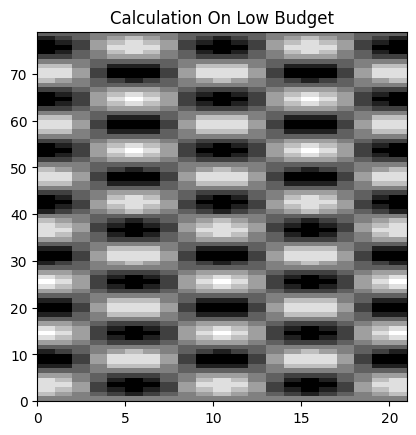

In [103]:
budget_low_opt = uniform(sampl(budget_low, phi, N_x_low, N_y_low, A, w_x, w_y), b_low)
plt.title('Calculation On Low Budget')
_ = plt.imshow((budget_low_opt+A)/2*A, cmap='gist_gray', origin='lower',
               extent=[0,N_x_low,0,N_y_low], aspect=N_x_low/N_y_low)

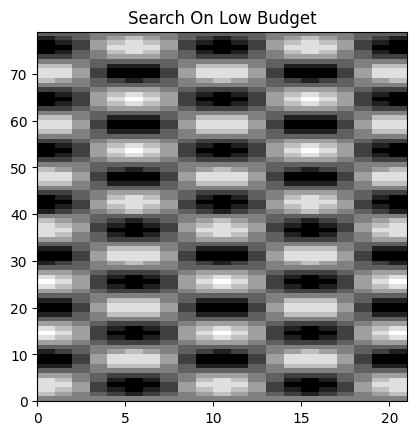

In [104]:
budget_low_s = uniform(sampl(budget_low, phi, N_x_low, N_y_low, A, w_x, w_y), b_low)
plt.title('Search On Low Budget')
_ = plt.imshow((budget_low_s+A)/2*A, cmap='gist_gray', origin='lower', extent=[0,N_x_low,0,N_y_low], aspect=N_x_low/N_y_low)

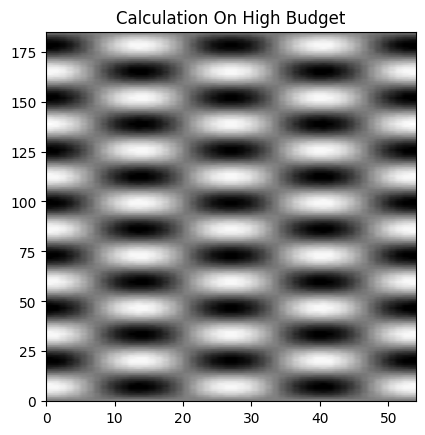

In [105]:
budget_high_opt = uniform(sampl(budget_high, phi, N_x_high, N_y_high, A, w_x, w_y), b_high)
plt.title('Calculation On High Budget')
_ = plt.imshow((budget_high_opt+A)/2*A, cmap='gist_gray', origin='lower',
               extent=[0,N_x_high,0,N_y_high], aspect=N_x_high/N_y_high)

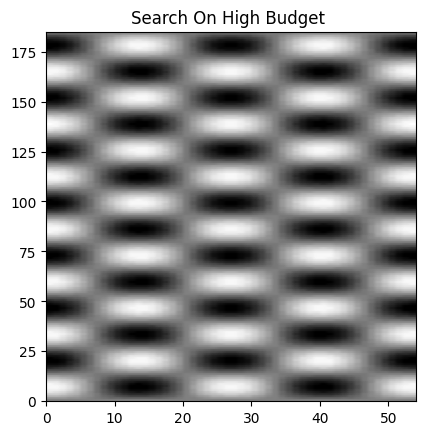

In [106]:
budget_high_s = uniform(sampl(budget_high, phi, N_x_high, N_y_high, A, w_x, w_y), b_high)
plt.title('Search On High Budget ')
_ = plt.imshow((budget_high_s+A)/2*A, cmap='gist_gray', origin='lower', extent=[0,N_x_high,0,N_y_high], aspect=N_x_high/N_y_high)

In [107]:
s1='best numeric low budget Nx = ' + str(N_x_low) + '  Ny = ' + str(N_y_low) + '  b = ' + str(b_low)
s2='best numeric high budget Nx = ' + str(N_x_high) + '  Ny = ' + str(N_y_high) + '  b = ' + str(b_high)
s3='best search low budget Nx = ' + str(N_x_low) + '  Ny = ' + str(N_y_low) + '  b = ' + str(b_low)
s4='best search high budget Nx = ' + str(N_x_high) + '  Ny = ' + str(N_y_high) + '  b = ' + str(b_high)
print(s1)
print(s2)
print(s3)
print(s4)

best numeric low budget Nx = 21  Ny = 79  b = 3
best numeric high budget Nx = 54  Ny = 185  b = 5
best search low budget Nx = 21  Ny = 79  b = 3
best search high budget Nx = 54  Ny = 185  b = 5


### Q1.h.

In [108]:
A = 2500
w_x = 7
w_y = 2
x_size = 1024
y_size = 1024
bits = 8
d_phi = np.zeros((x_size,y_size), dtype = np.float64)


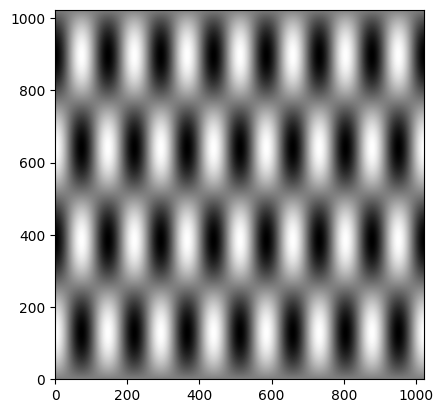

In [109]:
phi_plt = uniform(sampled=sampl(represent=d_phi, signal=phi, N_x=x_size, N_y=y_size, A=A, w_x=w_x, w_y=w_y), b=bits)
_ = plt.imshow((phi_plt+A)/2*A, cmap='gist_gray', origin='lower')

In [110]:
horizontal_deriv = np.zeros((x_size,y_size), dtype = np.float64)
vertical_deriv = np.zeros((x_size,y_size), dtype = np.float64)
digitized_horizontal_derivative = uniform(sampl(horizontal_deriv, horizontal_derivative ,x_size, y_size, A, w_x, w_y), bits)
digitized_vertical_derivative = uniform(sampl(vertical_deriv, vertical_derivative, x_size, y_size, A, w_x, w_y), bits)
value_range = d_phi.max() - d_phi.min()
s1='vertical-derivative energy : ' + str(energy_L2(digitized_vertical_derivative, x_size, y_size))
s2='horizontal-derivative energy : ' + str(energy_L2(digitized_horizontal_derivative, x_size, y_size))
s3='Phi range is: [' + str(phi_plt.min()) + ' , ' + str(phi_plt.max()) + ']'
print(s1);
print(s2);
print(s3);

vertical-derivative energy : 247221173.83261475
horizontal-derivative energy : 3016704139.3816543
Phi range is: [-2490.2314393881684 , 2509.762666363762]


In [111]:
horizontal_energy = energy_L2(digitized_horizontal_derivative, x_size, y_size)
vertical_energy = energy_L2(digitized_vertical_derivative, x_size, y_size)
N_x_low, N_y_low, b_low = best_calc(horizontal_energy, vertical_energy, value_range, 5000)
N_x_high, N_y_high, b_high = best_calc(horizontal_energy, vertical_energy, value_range, 50000)
budget_low_opt = np.zeros((N_y_low,N_x_low), dtype = np.float64)
high_opt = np.zeros((N_y_high, N_x_high), dtype = np.float64)
s1='best low budget  N_x =  ' + str(N_x_low) + '  N_y = ' + str(N_y_low) + '  b = ' + str(b_low)
s2='best high budget N_x =  ' + str(N_x_high) + '  N_y = ' + str(N_y_high) + '  b = ' + str(b_high)
print(s1)
print(s2)

best low budget  N_x =  72  N_y = 21  b = 3
best high budget N_x =  187  N_y = 53  b = 4


In [112]:
N_x_low, N_y_low, b_low = search_bit_allocation(horizontal_energy, vertical_energy, value_range, 5000)
N_x_high, N_y_high, b_high = search_bit_allocation(horizontal_energy, vertical_energy, value_range, 50000)

budget_low = np.zeros((N_y_low,N_x_low), dtype = np.float64)
budget_high = np.zeros((N_y_high, N_x_high), dtype = np.float64)

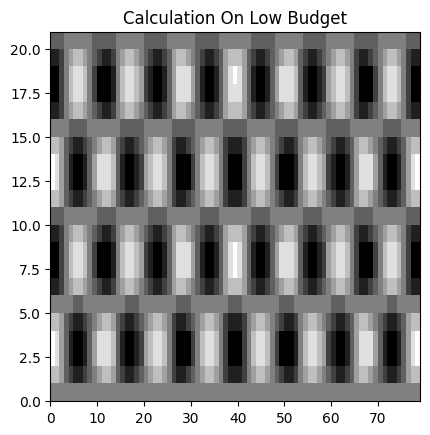

In [113]:
budget_low_opt = uniform(sampl(budget_low, phi, N_x_low, N_y_low, A, w_x, w_y), b_low)
plt.title('Calculation On Low Budget')
_ = plt.imshow((budget_low_opt+A)/2*A, cmap='gist_gray', origin='lower',
               extent=[0,N_x_low,0,N_y_low], aspect=N_x_low/N_y_low)

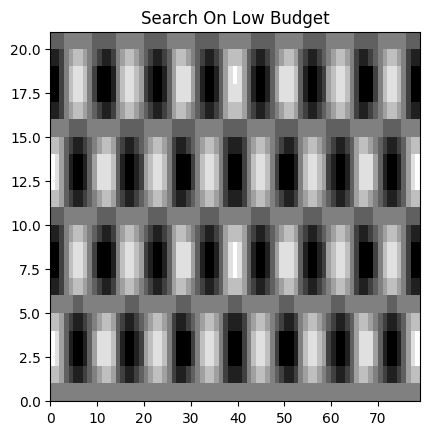

In [114]:
budget_low_s = uniform(sampl(budget_low, phi, N_x_low, N_y_low, A, w_x, w_y), b_low)
plt.title('Search On Low Budget')
_ = plt.imshow((budget_low_s+A)/2*A, cmap='gist_gray', origin='lower', extent=[0,N_x_low,0,N_y_low], aspect=N_x_low/N_y_low)

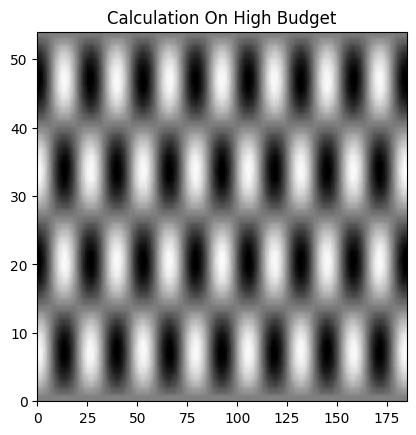

In [115]:
budget_high_opt = uniform(sampl(budget_high, phi, N_x_high, N_y_high, A, w_x, w_y), b_high)
plt.title('Calculation On High Budget')
_ = plt.imshow((budget_high_opt+A)/2*A, cmap='gist_gray', origin='lower',
               extent=[0,N_x_high,0,N_y_high], aspect=N_x_high/N_y_high)

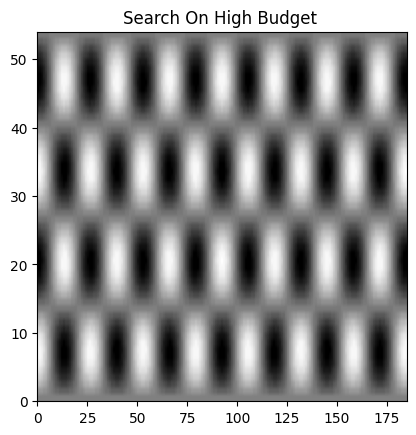

In [116]:
budget_high_s = uniform(sampl(budget_high, phi, N_x_high, N_y_high, A, w_x, w_y), b_high)
plt.title('Search On High Budget ')
_ = plt.imshow((budget_high_s+A)/2*A, cmap='gist_gray', origin='lower', extent=[0,N_x_high,0,N_y_high], aspect=N_x_high/N_y_high)

In [117]:
s1='best numeric low budget Nx = ' + str(N_x_low) + '  Ny = ' + str(N_y_low) + '  b = ' + str(b_low)
s2='best numeric high budget Nx = ' + str(N_x_high) + '  Ny = ' + str(N_y_high) + '  b = ' + str(b_high)
s3='best search low budget Nx = ' + str(N_x_low) + '  Ny = ' + str(N_y_low) + '  b = ' + str(b_low)
s4='best search high budget Nx = ' + str(N_x_high) + '  Ny = ' + str(N_y_high) + '  b = ' + str(b_high)
print(s1)
print(s2)
print(s3)
print(s4)

best numeric low budget Nx = 79  Ny = 21  b = 3
best numeric high budget Nx = 185  Ny = 54  b = 5
best search low budget Nx = 79  Ny = 21  b = 3
best search high budget Nx = 185  Ny = 54  b = 5
